In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nibabel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.utils.data import random_split

In [2]:
def apply_mask(aseg_image, brain_image, labels = [2, 41]):
    from scipy.ndimage import zoom
    brain_data = brain_image.get_fdata() 
    aseg_data = aseg_image.get_fdata() 
    brain_mask = np.zeros_like(aseg_data)
    for label in labels:
        brain_mask += np.where((aseg_data == label), 1, 0)

    segmented_brain_image = brain_data * brain_mask #applied mask on the brain image
#     resized_image = zoom(segmented_brain_image, np.array(target_size) / np.array(segmented_brain_image.shape), order=0)
    segmented_brain_image = nibabel.Nifti1Image(segmented_brain_image, affine=None) # Generating the nii image
    
    return segmented_brain_image

def resize_image(img_data):
    resized_img_data = torch.nn.functional.interpolate(
        torch.unsqueeze(torch.unsqueeze(torch.tensor(img_data), 0), 0),
        size=(100, 100, 100),
        mode='trilinear',
        align_corners=False,
    )
    return resized_img_data.squeeze().numpy()

In [3]:
csv_path = "ADNI1_Screening_1.5T_1_29_2024.csv"
# base = "/kaggle/input/adni-1-5t-fastsurfer-quickseg/ADNI-1.5T-FastSurfer-QuickSeg/"
mri_images = os.listdir("AD")
for i in os.listdir("CN"):
    mri_images.append(i)
for i in os.listdir("MCI"):
    mri_images.append(i)
    
csv_data = pd.read_csv(csv_path)
df = pd.DataFrame(csv_data)

In [4]:
for index, row in df.iterrows():
    file_name = row['Image Data ID'] + ".nii"
    if file_name not in mri_images:
        df = df.drop(index)
df.to_csv("filter_csv.csv")
csv_path = "filter.csv"

In [5]:
len(df), len(mri_images)

(367, 370)

In [6]:
df.head(20)

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
7,I31509,023_S_0855,MCI,M,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,9/05/2006,NiFTI,1/29/2024
9,I39152,130_S_0783,MCI,F,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/17/2006,NiFTI,1/29/2024
18,I40037,041_S_0598,MCI,M,72,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/16/2006,NiFTI,1/29/2024
20,I34524,099_S_0291,MCI,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/09/2006,NiFTI,1/29/2024
24,I34747,057_S_0941,MCI,F,73,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,10/11/2006,NiFTI,1/29/2024
26,I35591,011_S_1080,MCI,M,82,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,11/22/2006,NiFTI,1/29/2024
32,I35799,127_S_0112,MCI,M,71,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/13/2006,NiFTI,1/29/2024
34,I36949,036_S_0673,MCI,M,78,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/21/2006,NiFTI,1/29/2024
37,I31346,023_S_0217,MCI,F,84,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,2/21/2006,NiFTI,1/29/2024
44,I39701,014_S_0658,MCI,M,72,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/25/2006,NiFTI,1/29/2024


In [84]:
# class VGG3D(nn.Module):
#     def __init__(self, num_classes=3):  # Multiclass classification (e.g., AD, CN, another class)
#         super(VGG3D, self).__init__()
        
#         # Define the convolutional layers
#         self.features = nn.Sequential(
#             # Block 1
#             nn.Conv3d(1, 16, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(16, 16, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool3d(kernel_size=2, stride=2),  # Downsample
            
#             # Block 2
#             nn.Conv3d(16, 32, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(32, 32, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool3d(kernel_size=2, stride=2),  # Downsample
            
#             # Block 3
#             nn.Conv3d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool3d(kernel_size=2, stride=2),  # Downsample
            
#             # Block 4
#             nn.Conv3d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool3d(kernel_size=2, stride=2),  # Downsample
            
#             # Block 5
#             nn.Conv3d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool3d(kernel_size=2, stride=2),  # Downsample
#         )
        
#         # Fully connected layers
#         self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))  # Adaptive pooling to ensure fixed output size
#         self.classifier = nn.Sequential(
#             nn.Linear(128, 256),  # Match the flattened size from avgpool
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(256, 256),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(256, num_classes)  # Output layer for num_classes
#         )

#     def forward(self, x):
#         x = self.features(x)  # Convolutional blocks
#         x = self.avgpool(x)   # Adaptive pooling
#         x = torch.flatten(x, 1)  # Flatten for fully connected layers
#         x = self.classifier(x)  # Fully connected layers
#         return x

In [7]:
class VGG3D(nn.Module):
	def __init__(self, num_classes=3, input_shape=(1,100,100,100)): # input: input_shape:	[num_of_filters, kernel_size] (e.g. [256, 25])
		super(VGG3D, self).__init__()
		self.conv1 = nn.Sequential(
			nn.Conv3d(
				in_channels=input_shape[0],        # input height
				out_channels=8,       # n_filters
				kernel_size=(3,3,3),          # filter size
				padding=1
			),
            nn.ReLU(),
            nn.Conv3d(
				in_channels=8,        # input height
				out_channels=8,       # n_filters
				kernel_size=(3,3,3),          # filter size
				padding=1              
            ),
			nn.ReLU(),                  # activation
			nn.MaxPool3d(kernel_size=(2,2,2), stride=2) # choose max value in 2x2 area
		)
        
		self.conv2 = nn.Sequential(
			nn.Conv3d(
				in_channels=8,        # input height
				out_channels=16,       # n_filters
				kernel_size=(3,3,3),          # filter size
				padding=1              
			),
            nn.ReLU(),
            nn.Conv3d(
				in_channels=16,        # input height
				out_channels=16,       # n_filters
				kernel_size=(3,3,3),          # filter size
				padding=1                
			),
			nn.ReLU(),                  # activation
			nn.MaxPool3d(kernel_size=(2,2,2), stride=2) # choose max value in 2x2 area
		)
        
		self.conv3 = nn.Sequential(
			nn.Conv3d(
				in_channels=16,        # input height
				out_channels=32,       # n_filters
				kernel_size=(3,3,3),          # filter size
				padding=1               
			),
            nn.ReLU(),
            nn.Conv3d(
				in_channels=32,        # input height
				out_channels=32,       # n_filters
				kernel_size=(3,3,3),          # filter size
				padding=1                
			),
			nn.ReLU(),                  # activation
            nn.Conv3d(
				in_channels=32,        # input height
				out_channels=32,       # n_filters
				kernel_size=(3,3,3),          # filter size
				padding=1              
			),
			nn.ReLU(),
			nn.MaxPool3d(kernel_size=(2,2,2), stride=2) # choose max value in 2x2 area
		)

		self.conv4 = nn.Sequential(
			nn.Conv3d(
				in_channels=32,        # input height
				out_channels=64,       # n_filters
				kernel_size=(3,3,3),          # filter size
				padding=1                
			),
            nn.ReLU(),
            nn.Conv3d(
				in_channels=64,        # input height
				out_channels=64,       # n_filters
				kernel_size=(3,3,3),          # filter size
				padding=1                
			),
			nn.ReLU(),                  # activation
            nn.Conv3d(
				in_channels=64,        # input height
				out_channels=64,       # n_filters
				kernel_size=(3,3,3),          # filter size
				padding=1
			),
			nn.ReLU(),
			nn.MaxPool3d(kernel_size=(2,2,2), stride=2) # choose max value in 2x2 area
		)
		
		fc1_output_features=128     
		self.fc1 = nn.Sequential(
			 nn.Linear(13824, 128),
 			 nn.BatchNorm1d(128),            
			 nn.ReLU()
		 )

		fc2_output_features=64           
		self.fc2 = nn.Sequential(
			 nn.Linear(fc1_output_features, fc2_output_features),
			 nn.BatchNorm1d(fc2_output_features),
			 nn.ReLU()
		 )

		if(num_classes==2):
			self.out = nn.Linear(fc2_output_features, 2)
			self.out_act = nn.Sigmoid()
		else:
			self.out = nn.Linear(fc2_output_features, num_classes)
			self.out_act = nn.Softmax()


	def forward(self, x, drop_prob=0.8):

		x = self.conv1(x)
#		print(x.shape)        
		x = self.conv2(x)
#		print(x.shape)        
		x = self.conv3(x)
#		print(x.shape)        
		x = self.conv4(x)
#		print(x.shape)        
		x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, num_filter * w * h)
#		print(x.shape)        
		x = self.fc1(x)
		x = nn.Dropout(drop_prob)(x)
		x = self.fc2(x)
		#x = nn.Dropout(drop_prob)(x)        
		prob = self.out(x) # probability
# 		y_hat = self.out_act(prob) # label
# 		return y_hat, prob, x    # return x for visualization
		return prob

In [8]:
class MriDataset():
    def __init__(self, csv_path,transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform
        self.le = LabelEncoder()  # Add this line
        self.encoded_classes = self.le.fit_transform(self.data["Group"].values)  # Add this line

    
    def __len__(self):
        return len(self.data)

    def _load_image(self, img_id, label):
        # base = "/kaggle/input/adni-1-5t-fastsurfer-quickseg/ADNI-1.5T-FastSurfer-QuickSeg"
        base = "ADNI-1.5T-FastSurfer-QuickSeg/"
        img_id = img_id + ".nii"
        subject_dir = os.path.join(label, img_id, "mri")
        
        aseg_image = nibabel.load(os.path.join(subject_dir, "aparc.DKTatlas+aseg.deep.mgz"))
        brain_image = nibabel.load(os.path.join(subject_dir, "aparc.DKTatlas+aseg.deep.mgz"))
        
        image = apply_mask(aseg_image, brain_image) #applying the selected labels
        image = image.get_fdata()
        
        image_resized = resize_image(image) 
        image_resized = np.expand_dims(image_resized, axis=0)
        image_resized = torch.tensor(image_resized, dtype=torch.float)
        
        return image_resized

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx, 1]
        label = self.data.iloc[idx, 3]
        
        img = self._load_image(img_id, label) #loading the image
        one_hot_label = np.eye(len(self.le.classes_))[self.encoded_classes[idx]]
        
        #img = np.transpose(img, (2, 0, 1))    # Transpose the image to match PyTorch's tensor format (C x H x W)
        if self.transform:
            img = self.transform(img)
        return img, one_hot_label

In [9]:
# Define transformations
transform = transforms.Compose([
#     transforms.ToTensor(),
])

dataset = MriDataset(csv_path="filter_csv.csv", transform=transform)
train_size = int(0.7 * len(dataset))
validation_size = int(0.15 * len(dataset))
test_size = len(dataset)-(train_size + validation_size)

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

In [10]:
train_size, validation_size, test_size

(256, 55, 56)

In [11]:
# Load data
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, pin_memory = True)
validation_loader = DataLoader(validation_dataset, batch_size = 20, shuffle=True, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = 20, shuffle=True, pin_memory = True)


#model
model = VGG3D(num_classes=3)
# model = models.resnet18(pretrained = True)

# model.conv1 = nn.Conv2d(150, 64, kernel_size=7, stride=2, padding=3, bias=False)
# model.fc = nn.Linear(512, 3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [13]:
checkpoint_dir = "checkpoint"
os.makedirs(checkpoint_dir, exist_ok=True)

In [14]:
from tqdm import tqdm  # Import tqdm for progress tracking

# Set the device only once and use it throughout; no need to check every time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    print("CUDA can not be found, using CPU instead.")

num_epochs = 22  # number of epochs
loss_list = []  # To store loss after each epoch
accuracy_list = []  # To store accuracy after each epoch

# Move the model to the device once instead of inside the loop
model.to(device)

for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
    torch.cuda.empty_cache()  # Clear CUDA cache to free memory
    
    model.train()  # Set the model to training mode
    total = 0
    correct_count = 0
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}", unit="batch", leave=False):
        # for batch_idx, data in tqdm(enumerate(dataloader), desc=f"Epoch {epoch + 1}", unit="batch", leave=False):
        data, target = data.to(device, dtype=torch.float), target.to(device)
        
        # Forward pass
        # print("data shape", data.shape)
        output = model(data)
        # print("output shape", output.shape)
        # print("target shape", target.shape)
        loss = criterion(output, target)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
        # Adjust target shape if necessary (See Note below)
        if target.ndim > 1 and target.size(1) > 1:  # Case for one-hot encoded targets
            target = torch.argmax(target, dim=1)
        elif target.ndim > 1 and target.size(1) == 1:  # Case for extra singleton dimension
            target = target.squeeze()

        # Calculate accuracy
        correct = (torch.argmax(output, dim=1) == target).sum().item()
        correct_count += correct
        total += target.size(0)
    
    # Log the epoch's results
    accuracy = (correct_count / total) * 100
    loss_list.append(loss.item())
    accuracy_list.append(accuracy)
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}%")
    
    # # Save checkpoints at specified intervals
    # if (epoch + 1) % 5 == 0:stat_result = os.stat(filename)
    #     checkpoint_dir = "checkpoint_dir"  # We need to make sure this directory exists or create it
    #     if not os.path.exists(checkpoint_dir):
    #         os.makedirs(checkpoint_dir)
    #     checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pt")
    #     torch.save({
    #         'epoch': epoch + 1,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': loss.item(),
    #     }, checkpoint_path)
    #     print(f"Checkpoint saved to {checkpoint_path}")
    
# Save the final model
# torch.save(model.state_dict(), "model_final.pt")
print("Final model saved.")

CUDA can not be found, using CPU instead.


Epochs:   5%|▍         | 1/22 [05:04<1:46:39, 304.72s/epoch]

Epoch: 1/22, Loss: 1.2399, Accuracy: 30.0781%


Epochs:   9%|▉         | 2/22 [10:15<1:42:47, 308.39s/epoch]

Epoch: 2/22, Loss: 1.1287, Accuracy: 38.6719%


Epochs:  14%|█▎        | 3/22 [15:47<1:41:02, 319.10s/epoch]

Epoch: 3/22, Loss: 1.1090, Accuracy: 39.8438%


Epochs:  18%|█▊        | 4/22 [21:29<1:38:24, 328.05s/epoch]

Epoch: 4/22, Loss: 1.1719, Accuracy: 42.1875%


Epochs:  23%|██▎       | 5/22 [57:30<4:40:12, 988.95s/epoch]

Epoch: 5/22, Loss: 1.0959, Accuracy: 40.6250%


Epochs:  27%|██▋       | 6/22 [1:02:32<3:21:29, 755.56s/epoch]

Epoch: 6/22, Loss: 1.0966, Accuracy: 38.6719%


Epochs:  32%|███▏      | 7/22 [1:07:42<2:32:26, 609.79s/epoch]

Epoch: 7/22, Loss: 1.1129, Accuracy: 38.6719%


Epochs:  36%|███▋      | 8/22 [1:21:32<2:38:37, 679.83s/epoch]

Epoch: 8/22, Loss: 1.1186, Accuracy: 39.8438%


Epochs:  41%|████      | 9/22 [1:26:38<2:02:01, 563.16s/epoch]

Epoch: 9/22, Loss: 0.9140, Accuracy: 44.5312%


Epochs:  45%|████▌     | 10/22 [1:31:50<1:37:07, 485.59s/epoch]

Epoch: 10/22, Loss: 1.0543, Accuracy: 42.1875%


Epochs:  50%|█████     | 11/22 [1:37:14<1:19:57, 436.18s/epoch]

Epoch: 11/22, Loss: 1.1616, Accuracy: 47.2656%


Epochs:  55%|█████▍    | 12/22 [1:42:49<1:07:34, 405.44s/epoch]

Epoch: 12/22, Loss: 1.0092, Accuracy: 48.0469%


Epochs:  59%|█████▉    | 13/22 [1:48:31<57:54, 386.04s/epoch]  

Epoch: 13/22, Loss: 1.1040, Accuracy: 48.4375%


Epochs:  64%|██████▎   | 14/22 [1:54:15<49:47, 373.45s/epoch]

Epoch: 14/22, Loss: 1.0919, Accuracy: 44.9219%


Epochs:  68%|██████▊   | 15/22 [1:59:58<42:28, 364.14s/epoch]

Epoch: 15/22, Loss: 1.0713, Accuracy: 44.9219%


Epochs:  73%|███████▎  | 16/22 [2:05:33<35:31, 355.32s/epoch]

Epoch: 16/22, Loss: 0.9203, Accuracy: 45.7031%


Epochs:  77%|███████▋  | 17/22 [2:11:08<29:06, 349.36s/epoch]

Epoch: 17/22, Loss: 1.0574, Accuracy: 53.1250%


Epochs:  82%|████████▏ | 18/22 [2:16:50<23:08, 347.13s/epoch]

Epoch: 18/22, Loss: 0.9707, Accuracy: 51.9531%


Epochs:  86%|████████▋ | 19/22 [2:22:35<17:19, 346.40s/epoch]

Epoch: 19/22, Loss: 0.9289, Accuracy: 50.7812%


Epochs:  91%|█████████ | 20/22 [2:28:22<11:33, 346.81s/epoch]

Epoch: 20/22, Loss: 0.9017, Accuracy: 53.5156%


Epochs:  95%|█████████▌| 21/22 [2:34:22<05:50, 350.49s/epoch]

Epoch: 21/22, Loss: 0.8894, Accuracy: 57.0312%


Epochs: 100%|██████████| 22/22 [2:40:21<00:00, 437.32s/epoch]

Epoch: 22/22, Loss: 0.8008, Accuracy: 55.0781%
Final model saved.


Text(0.5, 1.0, 'Training Accuracy')

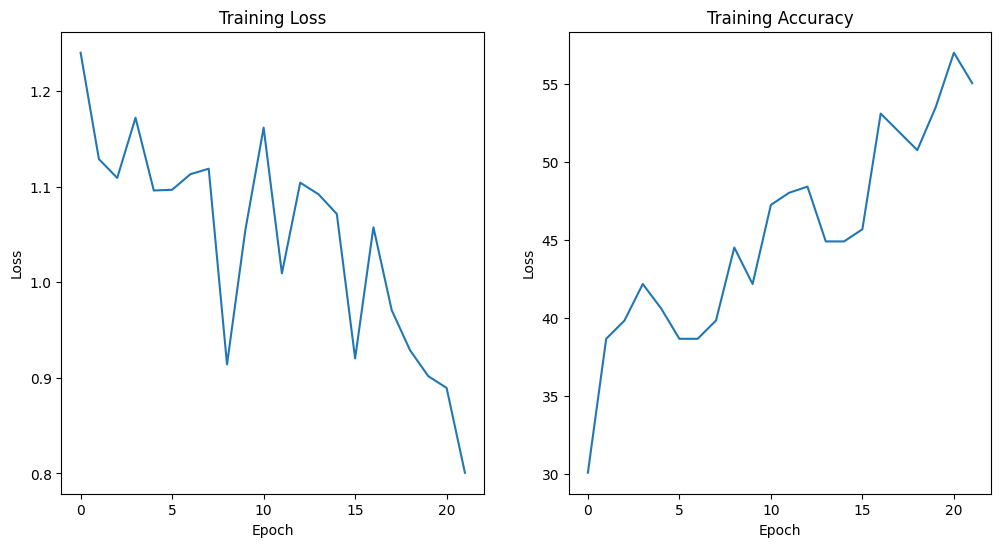

In [15]:
_, (loss_graph, accuracy_graph) = plt.subplots(1, 2, figsize=(12,6))

loss_graph.plot(loss_list)
loss_graph.set_xlabel("Epoch")
loss_graph.set_ylabel("Loss")
loss_graph.set_title("Training Loss")

accuracy_graph.plot(accuracy_list)
accuracy_graph.set_xlabel("Epoch")
accuracy_graph.set_ylabel("Loss")
accuracy_graph.set_title("Training Accuracy")

In [16]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data, target in validation_loader:
        model = model.to(device)
        data, target = data.to(device, dtype = torch.float), torch.tensor(target).to(device)
        output = model(data)
        output = output.cpu()
        target = target.cpu()
        
        all_preds.extend(torch.argmax(output, dim = 1))
        all_labels.extend(torch.argmax(target, dim=1))


accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation accuracy: {accuracy * 100:.2f}%")

/var/folders/t8/7_xrfl3x54j_kq_mpj3d6jp40000gn/T/ipykernel_5874/318942741.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = data.to(device, dtype = torch.float), torch.tensor(target).to(device)


Validation accuracy: 45.45%


In [17]:
#given the following data:
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for data, target in test_loader:
        model = model.to(device)
        data, target = data.to(device, dtype = torch.float), torch.tensor(target).to(device)
        output = model(data)
        output = output.cpu()
        target = target.cpu()
        
        test_preds.extend(torch.argmax(output, dim = 1))
        test_labels.extend(torch.argmax(target, dim=1))


accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {accuracy * 100:.2f}%")

/var/folders/t8/7_xrfl3x54j_kq_mpj3d6jp40000gn/T/ipykernel_5874/1349234065.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = data.to(device, dtype = torch.float), torch.tensor(target).to(device)


Test accuracy: 45.45%


In [18]:
from sklearn.metrics import precision_score, f1_score, roc_auc_score, accuracy_score

model.eval()
test_preds = []
test_labels = []

# Ensure evaluation without gradient calculation
with torch.no_grad():
    for data, target in test_loader:
        # Move data and model to device
        model = model.to(device)
        data, target = data.to(device, dtype=torch.float), target.to(device)
        
        # Forward pass
        output = model(data)
        
        # Collect predictions and true labels
        test_preds.extend(torch.argmax(output.cpu(), dim=1).numpy())
        test_labels.extend(torch.argmax(target.cpu(), dim=1).numpy())

# Compute accuracy
accuracy = accuracy_score(test_labels, test_preds)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Compute precision
precision = precision_score(test_labels, test_preds, average='weighted')  # 'weighted' for multi-class tasks
print(f"Precision: {precision:.2f}")

# Compute F1 score
f1 = f1_score(test_labels, test_preds, average='weighted')  # Adjust 'average' as needed
print(f"F1 Score: {f1:.2f}")

# Compute AUC-ROC
# For multi-class problems, provide one-hot encoding of test_labels and test_preds probabilities
if len(set(test_labels)) > 2:  # Check if multi-class
    test_labels_one_hot = np.eye(len(set(test_labels)))[test_labels]  # One-hot encoding
    output_probs = torch.nn.functional.softmax(output.cpu(), dim=1).numpy()
    auc_roc = roc_auc_score(test_labels_one_hot, output_probs, multi_class="ovr")
else:
    output_probs = torch.nn.functional.softmax(output.cpu(), dim=1)[:, 1].numpy()
    auc_roc = roc_auc_score(test_labels, output_probs)

print(f"AUC-ROC: {auc_roc:.2f}")


Test accuracy: 32.14%
Precision: 0.11
F1 Score: 0.16


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: Found input variables with inconsistent numbers of samples: [56, 16]

In [ ]:
# Compute AUC-ROC
if len(set(test_labels)) > 2:  # Multi-class case
    test_labels_one_hot = np.eye(len(set(test_labels)))[test_labels]  # One-hot encoding
    auc_roc = roc_auc_score(test_labels_one_hot, np.array(all_probs), multi_class="ovr")
else:  # Binary classification case
    auc_roc = roc_auc_score(test_labels, np.array(all_probs)[:, 1])  # Use positive class probabilities

print(f"AUC-ROC: {auc_roc:.2f}")

In [ ]:
from torchvision.models import resnet18
import torch
from torchsummary import summary
import torch.nn as nn

# Load and modify the model
model = resnet18()
model.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Modify for 2 input channels

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Display the summary
summary(model, input_size=(2, 224, 224))  # Adjust input size to match your data